In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

import matplotlib.pyplot as plt

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor


In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True)



h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [3]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Cal dates   : 2005-07-01 00:00:00 --- 2006-12-01 00:00:00  (n=18)
Test dates  : 2007-01-01 00:00:00 --- 2008-06-01 00:00:00  (n=18)


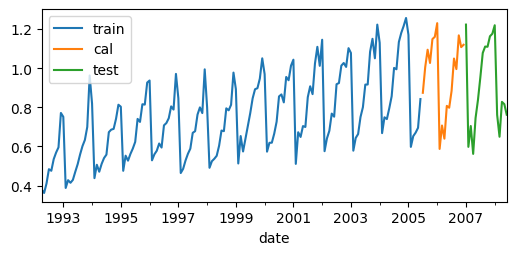

In [4]:
# ==============================================================================
test_steps = 18
cal_steps = 18
data_train = data[:-test_steps]
data_train, data_cal = data_train[0:-cal_steps], data_train[-cal_steps:]
data_test  = data[-test_steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)

print(
    f"Cal dates   : {data_cal.index.min()} --- "
    f"{data_cal.index.max()}  (n={len(data_cal)})"
)

print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')

ax.legend();

In [5]:
data_test['y'].name

'y'

In [6]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )

# we use 80% of the data for training and 20% for calibrating
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-31 15:52:14 
Last fit date: 2024-05-31 15:52:14 
Skforecast version: 0

# Predict without conformal

In [7]:
# Predictions
# ==============================================================================

non_cp_preds = forecaster.predict(steps=test_steps, last_window=data_cal['y'])
print(non_cp_preds)

[[1.120053 1.108038 1.168253 0.995709 1.049648 0.884312]]
[0.82609897]
[[0.82609897 1.120053   1.108038   1.168253   0.995709   1.049648  ]]
[0.67405903]
[[0.67405903 0.82609897 1.120053   1.108038   1.168253   0.995709  ]]
[0.71852211]
[[0.71852211 0.67405903 0.82609897 1.120053   1.108038   1.168253  ]]
[0.78398823]
[[0.78398823 0.71852211 0.67405903 0.82609897 1.120053   1.108038  ]]
[0.81217049]
[[0.81217049 0.78398823 0.71852211 0.67405903 0.82609897 1.120053  ]]
[0.88659016]
[[0.88659016 0.81217049 0.78398823 0.71852211 0.67405903 0.82609897]]
[0.89732586]
[[0.89732586 0.88659016 0.81217049 0.78398823 0.71852211 0.67405903]]
[0.96482462]
[[0.96482462 0.89732586 0.88659016 0.81217049 0.78398823 0.71852211]]
[1.00497002]
[[1.00497002 0.96482462 0.89732586 0.88659016 0.81217049 0.78398823]]
[0.95915193]
[[0.95915193 1.00497002 0.96482462 0.89732586 0.88659016 0.81217049]]
[0.7675686]
[[0.7675686  0.95915193 1.00497002 0.96482462 0.89732586 0.88659016]]
[0.64908575]
[[0.64908575 0.76

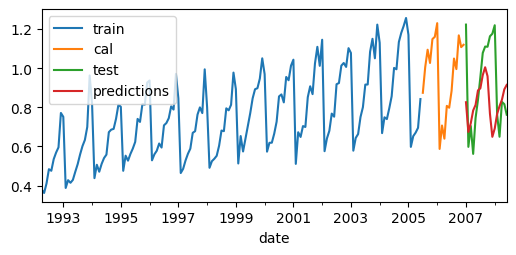

In [8]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')
non_cp_preds.plot(ax=ax, label='predictions')
ax.legend();

# Predict with conformal


In [9]:
data_cal['y']

date
2005-07-01    0.874336
2005-08-01    1.006497
2005-09-01    1.094736
2005-10-01    1.027043
2005-11-01    1.149232
2005-12-01    1.160712
2006-01-01    1.230691
2006-02-01    0.587135
2006-03-01    0.706959
2006-04-01    0.639641
2006-05-01    0.807405
2006-06-01    0.797970
2006-07-01    0.884312
2006-08-01    1.049648
2006-09-01    0.995709
2006-10-01    1.168253
2006-11-01    1.108038
2006-12-01    1.120053
Freq: MS, Name: y, dtype: float64

In [10]:
# Calibrate
# ==============================================================================
forecaster.calibrate_conformal(data_cal['y'])


Conformal prediction has been calibrated. The model is now ready to predict conformal intervals.



In [11]:
forecaster.regressor_conformal.valid_methods_

['enbpi', 'aci']

In [12]:
# see estimator
forecaster.regressor_conformal.estimator

RandomForestRegressor(random_state=123)

In [13]:
forecaster.regressor_conformal.method  # this should be aci, I patch it by reassigning 'aci' to it.

'base'

In [14]:
# Predictions
# ==============================================================================
predictions = forecaster.predict_conformal_interval(steps=test_steps,
                                                    last_window = data_cal['y'],
                                                    desired_coverage= 0.9)
predictions

[[1.120053 1.108038 1.168253 0.995709 1.049648 0.884312]]
[0.82609897]
[[0.82609897 1.120053   1.108038   1.168253   0.995709   1.049648  ]]
[0.67405903]
[[0.67405903 0.82609897 1.120053   1.108038   1.168253   0.995709  ]]
[0.71852211]
[[0.71852211 0.67405903 0.82609897 1.120053   1.108038   1.168253  ]]
[0.78398823]
[[0.78398823 0.71852211 0.67405903 0.82609897 1.120053   1.108038  ]]
[0.81217049]
[[0.81217049 0.78398823 0.71852211 0.67405903 0.82609897 1.120053  ]]
[0.88659016]
[[0.88659016 0.81217049 0.78398823 0.71852211 0.67405903 0.82609897]]
[0.89732586]
[[0.89732586 0.88659016 0.81217049 0.78398823 0.71852211 0.67405903]]
[0.96482462]
[[0.96482462 0.89732586 0.88659016 0.81217049 0.78398823 0.71852211]]
[1.00497002]
[[1.00497002 0.96482462 0.89732586 0.88659016 0.81217049 0.78398823]]
[0.95915193]
[[0.95915193 1.00497002 0.96482462 0.89732586 0.88659016 0.81217049]]
[0.7675686]
[[0.7675686  0.95915193 1.00497002 0.96482462 0.89732586 0.88659016]]
[0.64908575]
[[0.64908575 0.76

,pred,lower_bound,upper_bound
2007-01-01,0.826099,0.436971,1.145696
2007-02-01,0.674059,0.284931,0.993656
2007-03-01,0.718522,0.329394,1.038119
2007-04-01,0.783988,0.394860,1.103585
2007-05-01,0.812170,0.423043,1.131767
2007-06-01,0.886590,0.497462,1.206187
2007-07-01,0.897326,0.508198,1.216923
2007-08-01,0.964825,0.575697,1.284422
2007-09-01,1.004970,0.615842,1.324567
2007-10-01,0.959152,0.570024,1.278749


In [15]:
preds, y_pis = predictions['pred'].to_numpy(), predictions[['lower_bound', 'upper_bound']].to_numpy()

In [16]:
preds

array([0.82609897, 0.67405903, 0.71852211, 0.78398823, 0.81217049,
       0.88659016, 0.89732586, 0.96482462, 1.00497002, 0.95915193,
       0.7675686 , 0.64908575, 0.69187916, 0.76688041, 0.80618578,
       0.83875634, 0.89210719, 0.91486064])

In [17]:
y_pis

array([[0.43697105, 1.14569586],
       [0.28493111, 0.99365592],
       [0.32939419, 1.038119  ],
       [0.39486031, 1.10358512],
       [0.42304257, 1.13176738],
       [0.49746224, 1.20618705],
       [0.50819794, 1.21692275],
       [0.5756967 , 1.28442151],
       [0.6158421 , 1.32456691],
       [0.57002401, 1.27874882],
       [0.37844068, 1.08716549],
       [0.25995783, 0.96868264],
       [0.30275124, 1.01147605],
       [0.37775249, 1.0864773 ],
       [0.41705786, 1.12578267],
       [0.44962842, 1.15835323],
       [0.50297927, 1.21170408],
       [0.52573272, 1.23445753]])

In [18]:
# compare with non cp predictions to see if they are the same. They are not, which makes sense as we fit the model on a different data set.
np.isclose(preds, non_cp_preds.to_numpy())

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [19]:
lower = y_pis[:, 0]
upper = y_pis[:, 1]

lower

array([0.43697105, 0.28493111, 0.32939419, 0.39486031, 0.42304257,
       0.49746224, 0.50819794, 0.5756967 , 0.6158421 , 0.57002401,
       0.37844068, 0.25995783, 0.30275124, 0.37775249, 0.41705786,
       0.44962842, 0.50297927, 0.52573272])

In [20]:
data_test.index

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

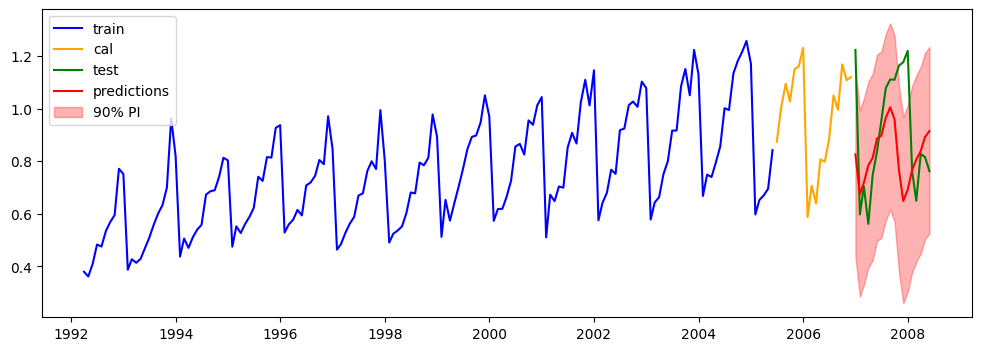

In [21]:
# visualize predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(data_train.index, data_train['y'], color='blue', label='train')
ax.plot(data_cal.index, data_cal['y'], color='orange', label='cal')
ax.plot(data_test.index, data_test['y'], color='green', label='test')

ax.plot(data_test.index, preds, color='red', label='predictions')

# plot intervals
ax.fill_between(data_test.index, lower, upper, color='red', alpha=0.3, label='90% PI')


ax.legend();
plt.show()
